# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

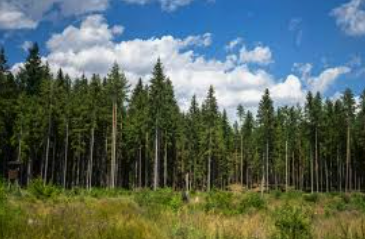

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [1]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

2025-09-14 07:35:58.634447: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-14 07:36:12.642604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-14 07:36:22.408101: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [4]:
# Your code here



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

random_seed = 100  

X_train, X_test, y_train, y_test = train_test_split(
    X_sub,
    y_sub,
    test_size=0.2,
    stratify=y_sub,
    random_state=random_seed
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (15383, 54) Test shape: (3846, 54)


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print("Feature means after scaling (first 5):", X_train.mean(axis=0)[:5])
print("Feature stds after scaling (first 5):", X_train.std(axis=0)[:5])

Feature means after scaling (first 5): [ 1.85554404e-16  1.08268938e-16  9.35277916e-17 -4.79222576e-18
 -4.18814549e-17]
Feature stds after scaling (first 5): [1. 1. 1. 1. 1.]


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



In [6]:
# Your code here

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

num_features = X_train.shape[1]
num_classes = 7  # y in {0..6}

model = Sequential([
    Input(shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

2025-09-14 07:36:24.778917: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # optional: use test set for validation
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3640 - loss: 1.7204 - val_accuracy: 0.4756 - val_loss: 1.4425
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5377 - loss: 1.2689 - val_accuracy: 0.5866 - val_loss: 1.1291
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5998 - loss: 1.0456 - val_accuracy: 0.6170 - val_loss: 0.9732
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6269 - loss: 0.9324 - val_accuracy: 0.6378 - val_loss: 0.8940
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6485 - loss: 0.8703 - val_accuracy: 0.6526 - val_loss: 0.8478
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6659 - loss: 0.8303 - val_accuracy: 0.6648 - val_loss: 0.8158
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6782 - loss: 0.8003 - val_accuracy: 0.6747 - val_loss: 0.7912
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6871 - loss: 0.7765 - val_accuracy: 0.

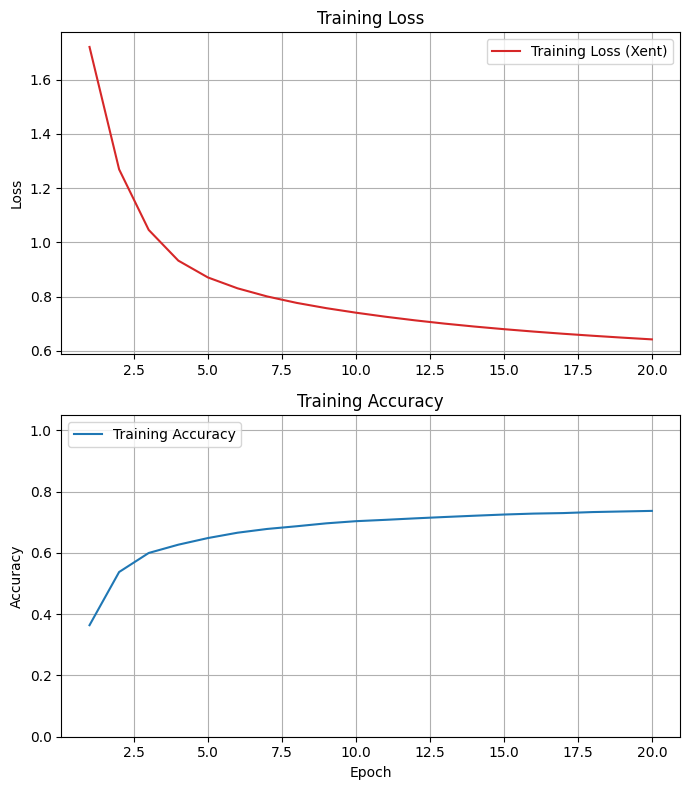

Final Training Loss:     0.6419
Final Training Accuracy: 0.7372


In [9]:
plot_history(history)


In [10]:
# Set a1a to the final training accuracy at epoch 20

a1a = history.history['accuracy'][-1]            

In [11]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7372


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


=== Training with batch_size = 4 ===


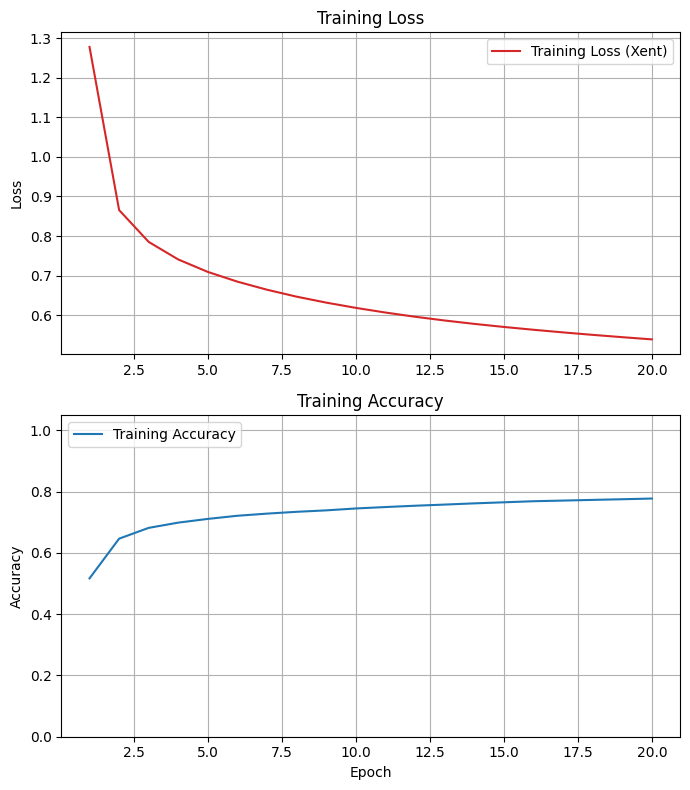

Final Training Loss:     0.5390
Final Training Accuracy: 0.7775
Final Train Accuracy: 0.7775, Final Val Accuracy: 0.7663

=== Training with batch_size = 8 ===


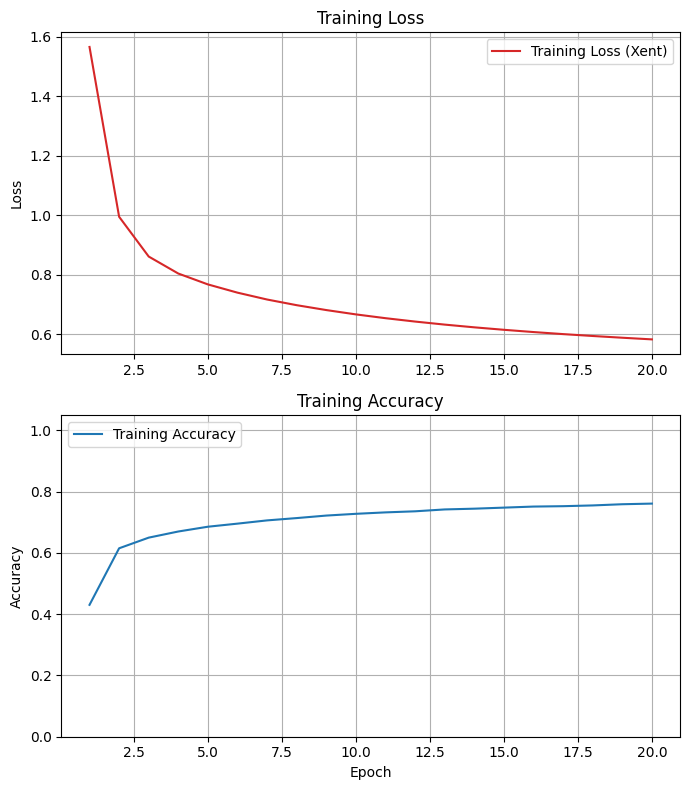

Final Training Loss:     0.5822
Final Training Accuracy: 0.7610
Final Train Accuracy: 0.7610, Final Val Accuracy: 0.7491

=== Training with batch_size = 16 ===


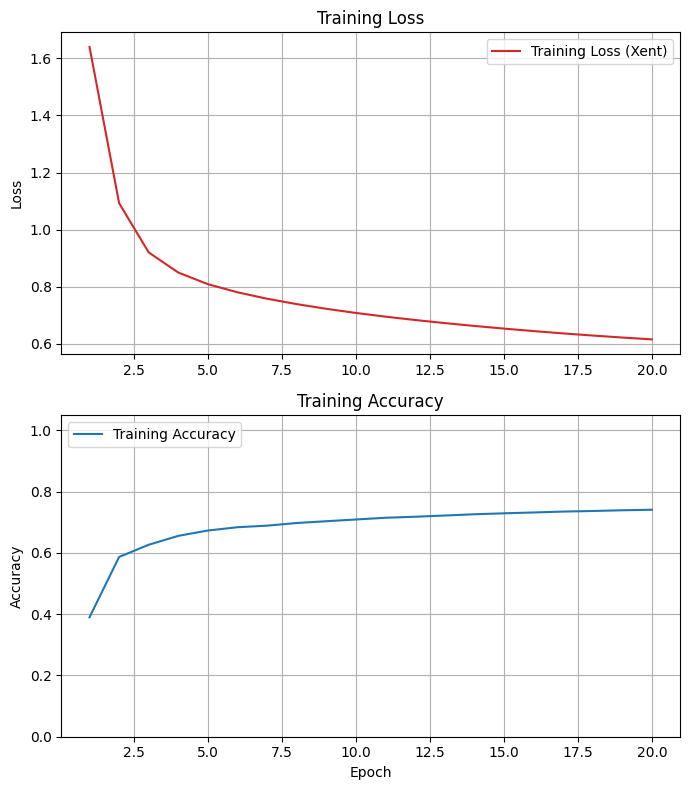

Final Training Loss:     0.6155
Final Training Accuracy: 0.7409
Final Train Accuracy: 0.7409, Final Val Accuracy: 0.7374

=== Training with batch_size = 128 ===


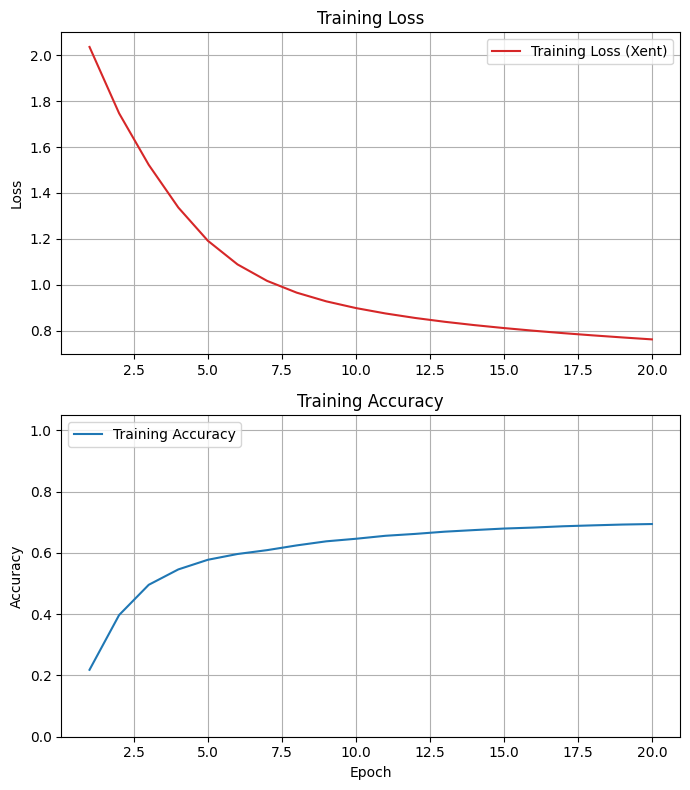

Final Training Loss:     0.7621
Final Training Accuracy: 0.6943
Final Train Accuracy: 0.6943, Final Val Accuracy: 0.6963


In [12]:
# Your code here


import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

np.random.seed(100)
tf.random.set_seed(100)

num_features = X_train.shape[1]
num_classes = 7

def build_model():
    model = Sequential([
        Input(shape=(num_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

batch_sizes = [4, 8, 16, 128]

for bs in batch_sizes:
    print(f"\n=== Training with batch_size = {bs} ===")
    model = build_model()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=bs,
        verbose=0
    )
    plot_history(history)
    final_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    print(f"Final Train Accuracy: {final_acc:.4f}, Final Val Accuracy: {val_acc:.4f}")



In [13]:
histories = {} 

for bs in [4, 8, 16, 128]:
    model = build_model()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=bs,
        verbose=0
    )
    histories[bs] = history   



In [14]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = max(histories, key=lambda bs: histories[bs].history['accuracy'][-1])           # Replace 0 with your answer

In [15]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [16]:
# Set a2b to the best accuracy score found

a2b = histories[a2a].history['accuracy'][-1]            # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7798


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



=== Training with Adam(lr=0.001) ===


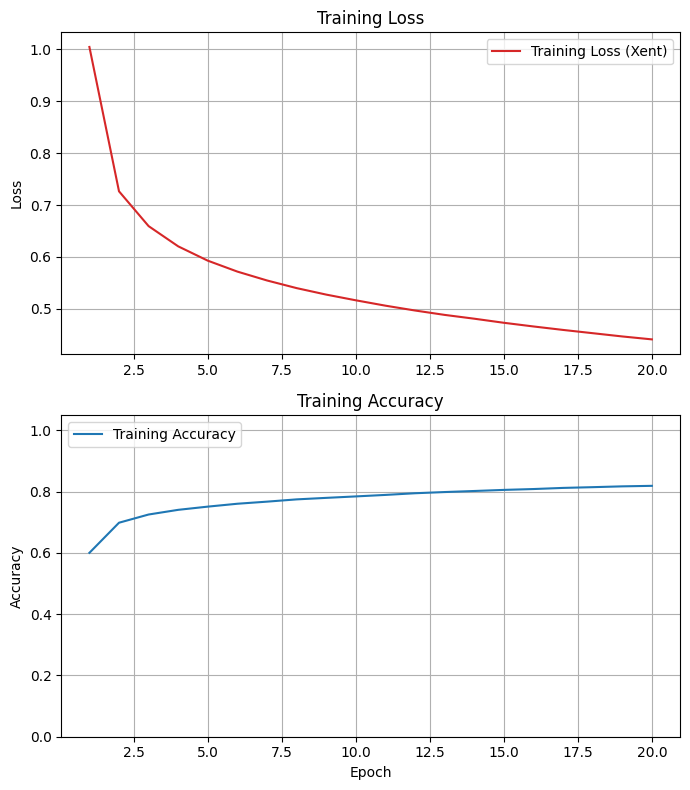

Final Training Loss:     0.4409
Final Training Accuracy: 0.8190

=== Training with Adam(lr=0.0005) ===


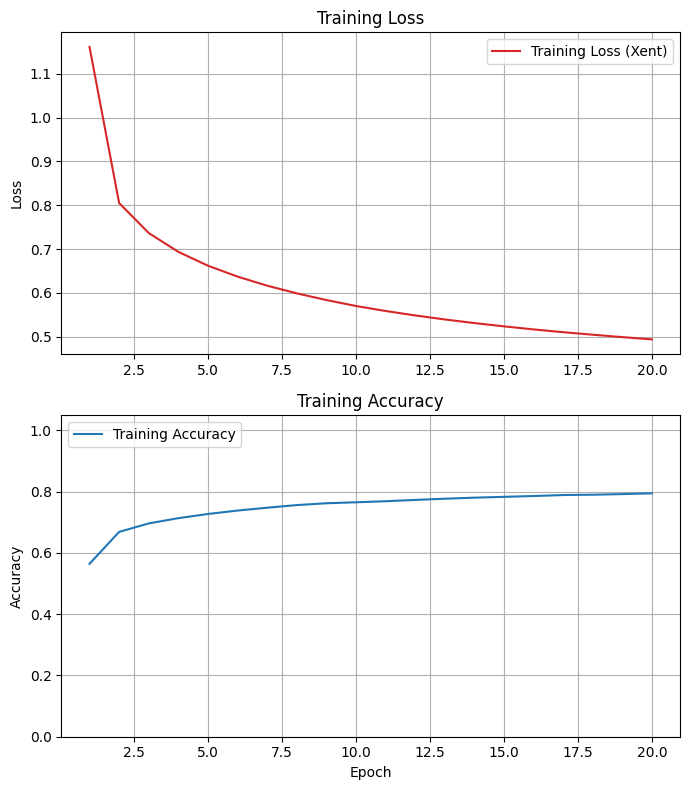

Final Training Loss:     0.4940
Final Training Accuracy: 0.7946

=== Training with Adam(lr=0.0001) ===


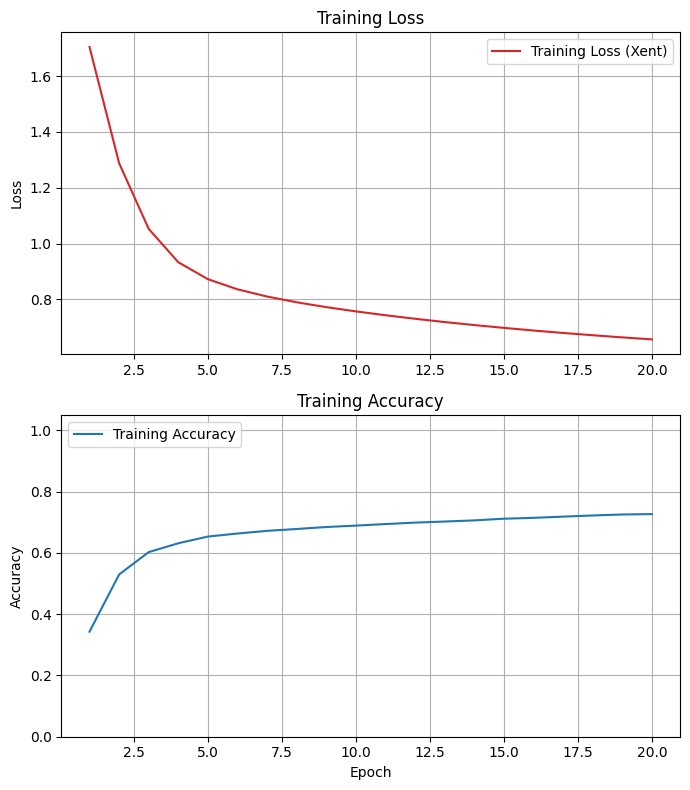

Final Training Loss:     0.6571
Final Training Accuracy: 0.7267

=== Training with Adam(lr=5e-05) ===


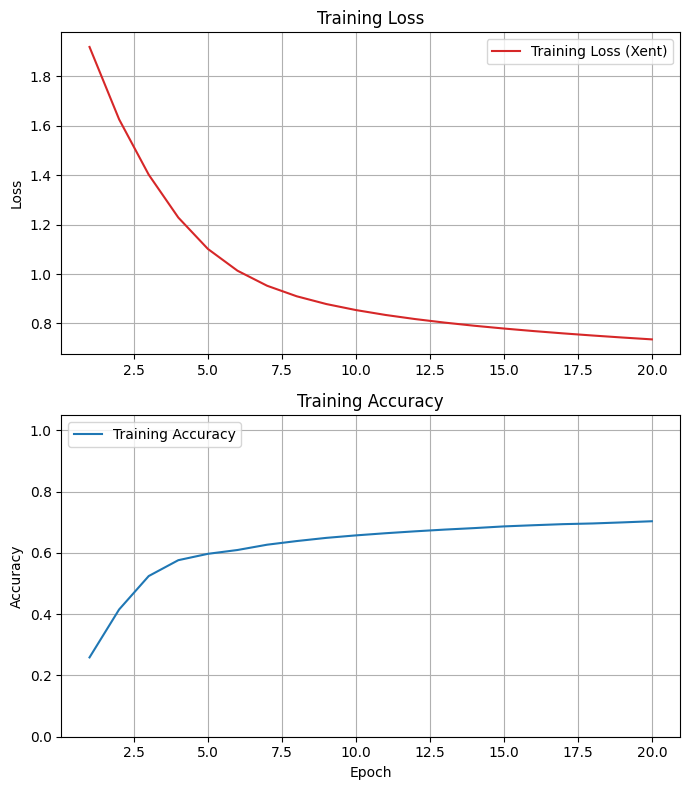

Final Training Loss:     0.7355
Final Training Accuracy: 0.7034

=== Training with Adam(lr=1e-05) ===


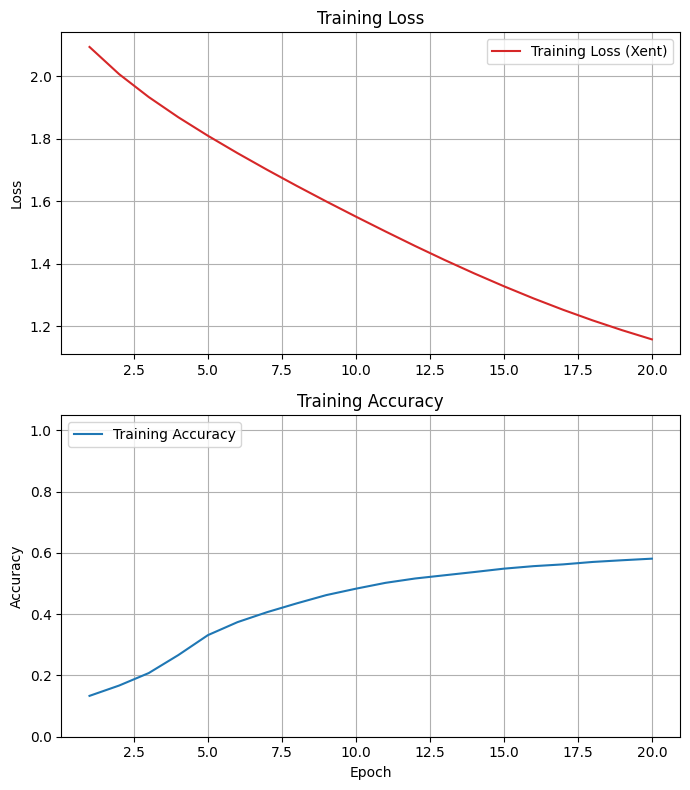

Final Training Loss:     1.1583
Final Training Accuracy: 0.5812


In [18]:
# Your code here

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Reproducibility
np.random.seed(100)
tf.random.set_seed(100)

num_features = X_train.shape[1]
num_classes = 7

def build_model(lr):
    model = Sequential([
        Input(shape=(num_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
histories = {}

for lr in lrs:
    print(f"\n=== Training with Adam(lr={lr}) ===")
    model = build_model(lr)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),  
        epochs=20,
        batch_size=32,
        verbose=0
    )
    histories[lr] = history
    plot_history(history)   




In [19]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = max(histories, key=lambda lr: histories[lr].history['accuracy'][-1]) # Replace 0.0 with your answer

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [21]:
# Set a3b to the accuracy found by the best learning rate

a3b = histories[a3a].history['accuracy'][-1] # Replace 0.0 with your answer

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8190


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


=== CosineDecay initial_learning_rate = 0.01 ===


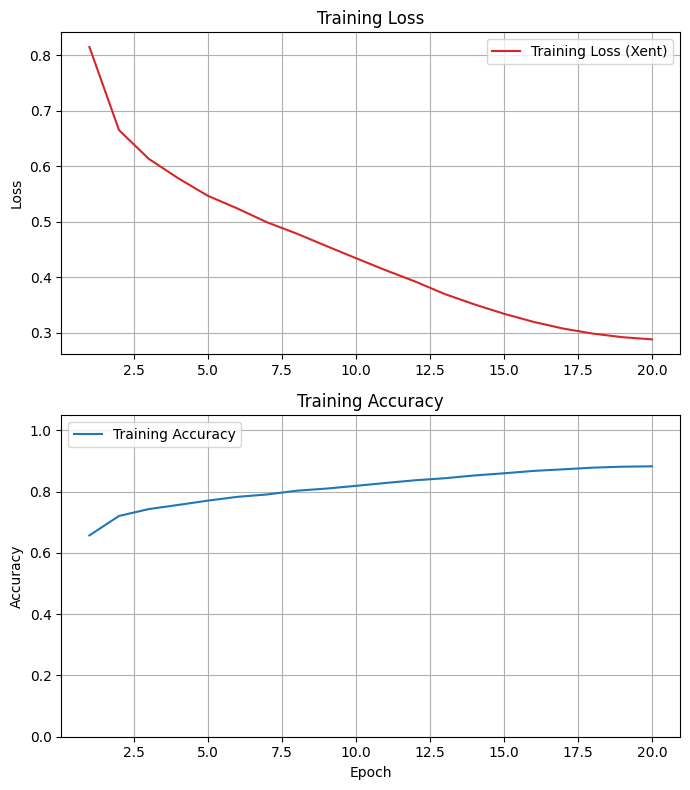

Final Training Loss:     0.2884
Final Training Accuracy: 0.8827

=== CosineDecay initial_learning_rate = 0.005 ===


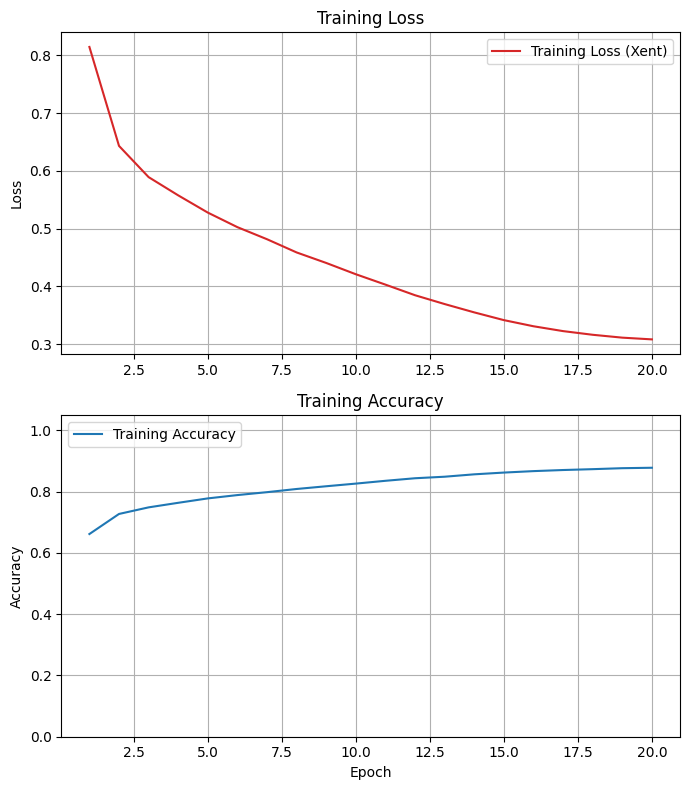

Final Training Loss:     0.3084
Final Training Accuracy: 0.8780

=== CosineDecay initial_learning_rate = 0.001 ===


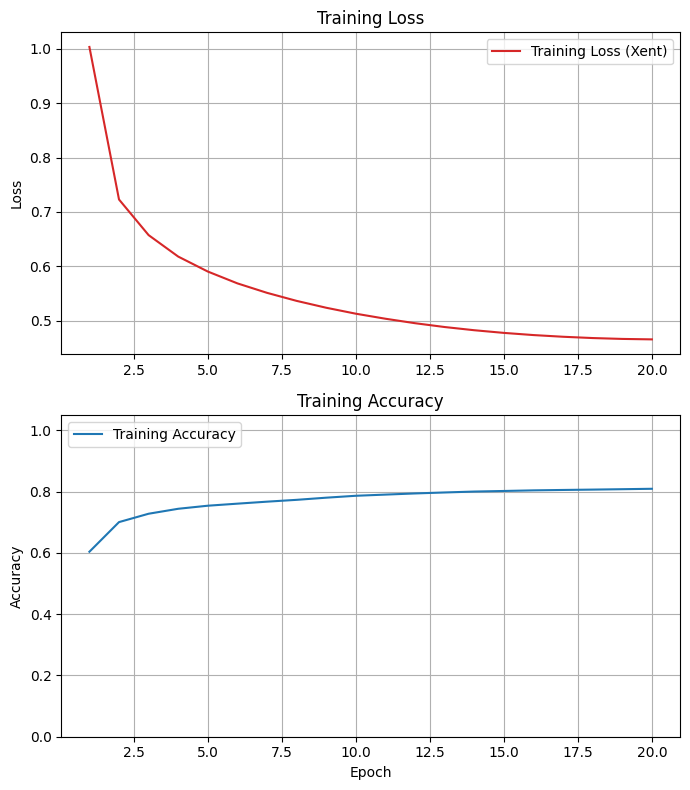

Final Training Loss:     0.4659
Final Training Accuracy: 0.8093

=== CosineDecay initial_learning_rate = 0.0005 ===


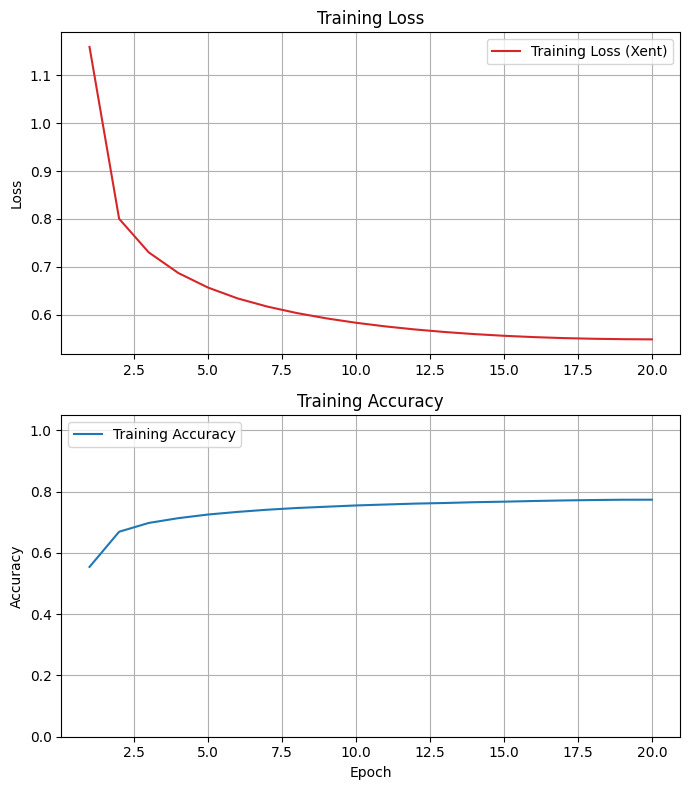

Final Training Loss:     0.5489
Final Training Accuracy: 0.7737

=== CosineDecay initial_learning_rate = 0.0001 ===


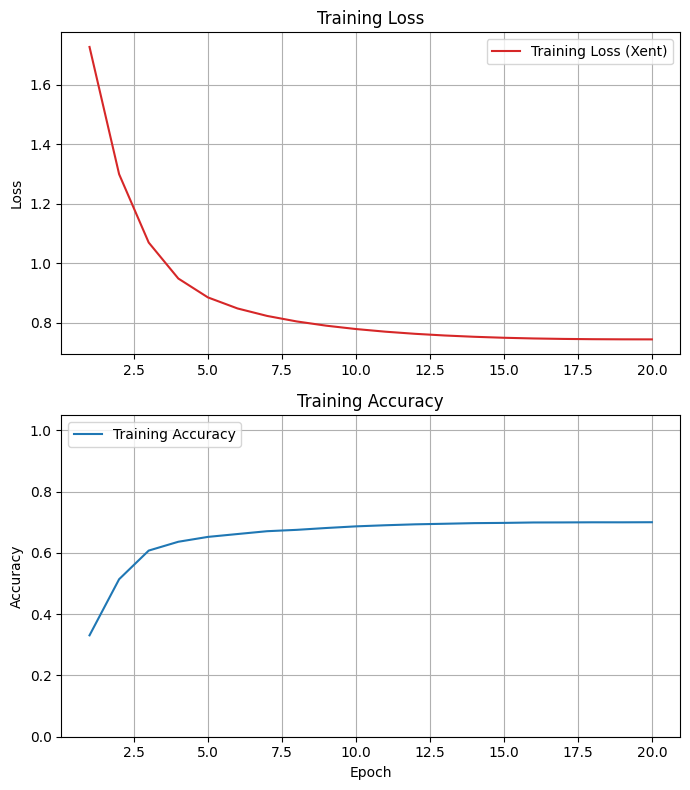

Final Training Loss:     0.7435
Final Training Accuracy: 0.7002

Best initial LR by VAL accuracy: 0.005 (val_acc=0.8362)


In [23]:
# Your code here

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

np.random.seed(100)
tf.random.set_seed(100)

num_features = X_train.shape[1]
num_classes = 7
epochs = 20
batch_size = 32
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = steps_per_epoch * epochs

def build_model(lr_schedule):
    model = Sequential([
        Input(shape=(num_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

initial_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
histories = {}

for init_lr in initial_lrs:
    print(f"\n=== CosineDecay initial_learning_rate = {init_lr} ===")
    lr_schedule = CosineDecay(
        initial_learning_rate=init_lr,
        decay_steps=total_steps,      
        alpha=0.0                     
    )
    model = build_model(lr_schedule)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    histories[init_lr] = history
    plot_history(history)

best_init_lr = max(histories, key=lambda lr: histories[lr].history['val_accuracy'][-1])
best_val_acc = histories[best_init_lr].history['val_accuracy'][-1]
print(f"\nBest initial LR by VAL accuracy: {best_init_lr} (val_acc={best_val_acc:.4f})")



In [24]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = max(histories, key=lambda lr: histories[lr].history['accuracy'][-1]) # Replace 0.0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [26]:
# Set a4b to the best accuracy found

a4b = histories[a4a].history['accuracy'][-1] # Replace 0.0 with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8827


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

In [ ]:
# Your code here -- add as many cells as you need

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

np.random.seed(100)
tf.random.set_seed(100)

epochs = 20
const_lrs     = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
cosine_lrs    = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
batch_sizes   = [4, 8, 16, 128]   

num_features = X_train.shape[1]
num_classes  = 7

def build_model():
    return Sequential([
        Input(shape=(num_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

def train_once(batch_size, optimizer):
    model = build_model()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    return model, history

best = {
    "val_acc": -1.0,
    "sched": None,
    "lr": None,
    "batch_size": None,
    "history": None,
    "model": None
}

for lr in const_lrs:
    for bs in batch_sizes:
        opt = Adam(learning_rate=lr)
        model, history = train_once(bs, opt)
        val_acc = history.history['val_accuracy'][-1]
        if val_acc > best["val_acc"]:
            best.update(dict(val_acc=val_acc, sched="constant", lr=lr,
                             batch_size=bs, history=history, model=model))

for init_lr in cosine_lrs:
    for bs in batch_sizes:
        steps_per_epoch = int(np.ceil(len(X_train) / bs))
        total_steps = steps_per_epoch * epochs
        lr_schedule = CosineDecay(initial_learning_rate=init_lr,
                                  decay_steps=total_steps, alpha=0.0)
        opt = Adam(learning_rate=lr_schedule)
        model, history = train_once(bs, opt)
        val_acc = history.history['val_accuracy'][-1]
        if val_acc > best["val_acc"]:
            best.update(dict(val_acc=val_acc, sched="cosine", lr=init_lr,
                             batch_size=bs, history=history, model=model))

print("\n=== Best configuration (by validation accuracy at epoch 20) ===")
print(f"Scheduler     : {best['sched']}")
print(f"Learning rate : {best['lr']}")
print(f"Batch size    : {best['batch_size']}")
print(f"Val accuracy  : {best['val_acc']:.4f}")

plot_history(best["history"])

test_loss, test_acc = best["model"].evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")





In [ ]:
# Set a5a to the best training accuracy found by your best model

a5a  = best["history"].history['accuracy'][-1] # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8827


In [ ]:
# Set a5b to the test accuracy found by your best model

a5b = test_acc            # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8409


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


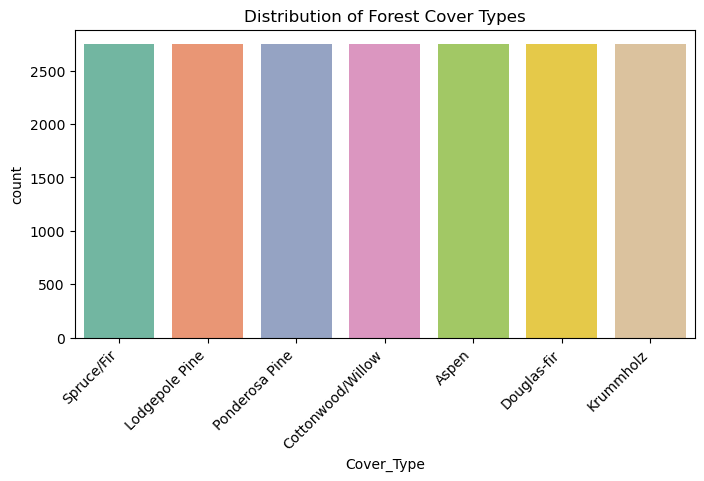

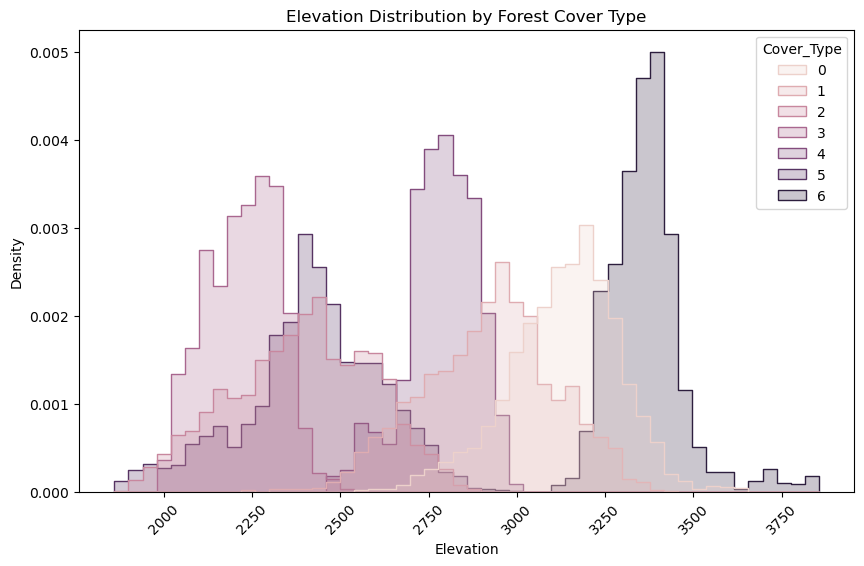

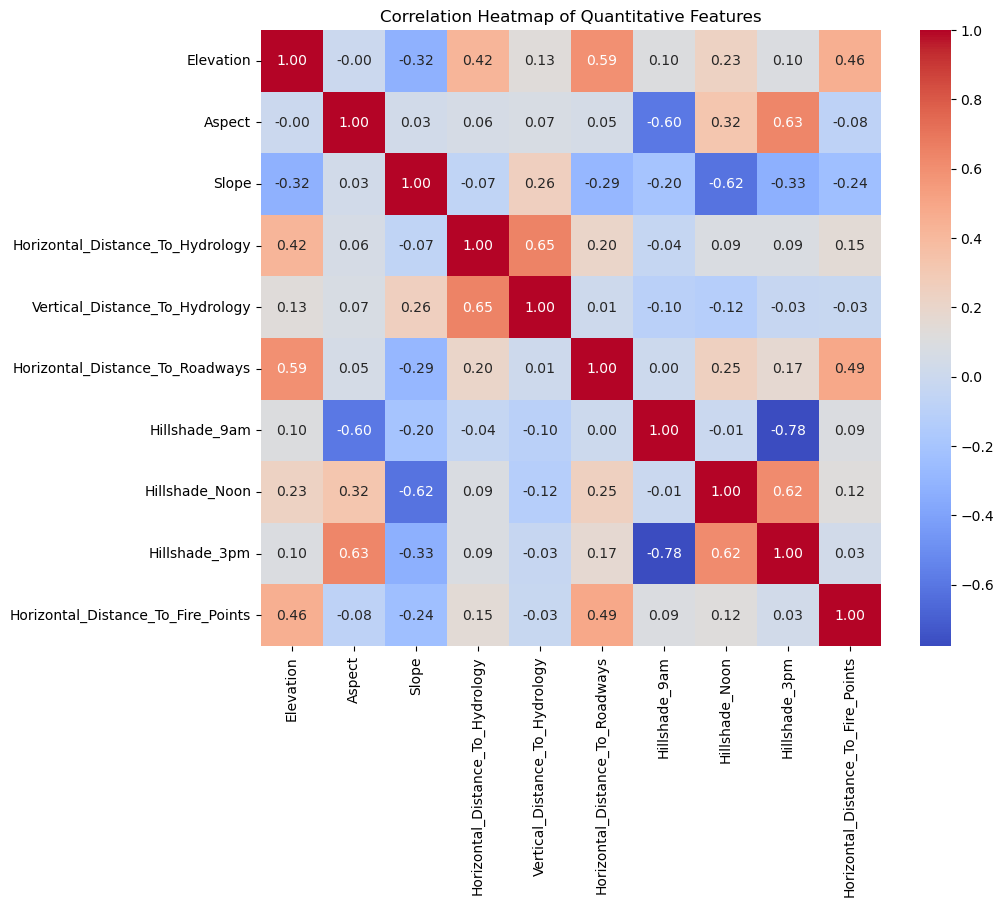

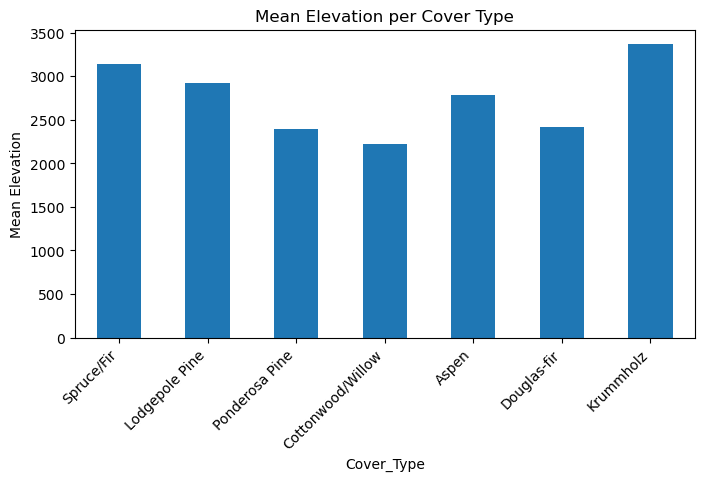

In [ ]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
